Objective
Build a machine learning pipeline to predict cardiovascular disease risk using patient health indicators such as age, BMI, blood pressure, cholesterol, and lifestyle habits.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Load dataset
df = pd.read_csv("cardio_train.csv", sep=';')

print(df.shape)
df.head()

(70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [12]:
df['age_years'] = (df['age'] / 365).astype(int)

In [14]:
df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)


In [16]:
# Remove extreme blood pressure values
df = df[(df['ap_hi'] > 80) & (df['ap_hi'] < 200)]
df = df[(df['ap_lo'] > 40) & (df['ap_lo'] < 150)]

# Filter out unrealistic height and weight
df = df[(df['height'] > 120) & (df['height'] < 220)]
df = df[(df['weight'] > 30) & (df['weight'] < 200)]

# filter out BMI outliers
df = df[(df['bmi'] > 10) & (df['bmi'] < 60)]


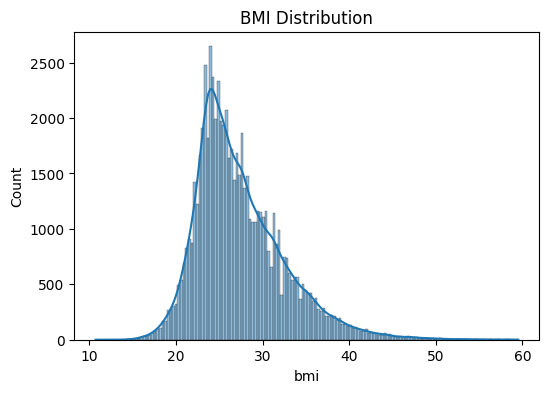

In [18]:
# Distribution of BMI
plt.figure(figsize=(6, 4))
sns.histplot(df['bmi'], kde=True)
plt.title("BMI Distribution")
plt.show()

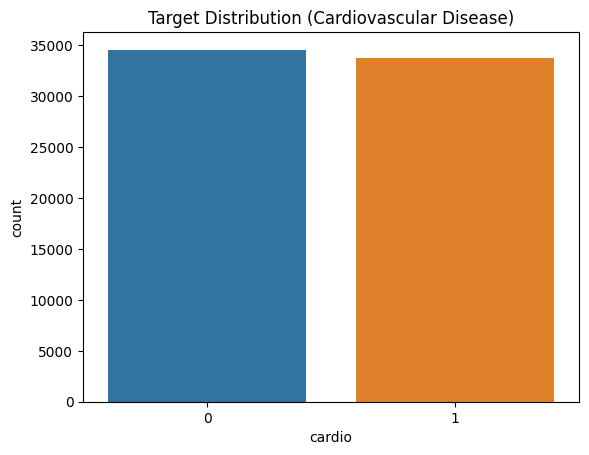

In [20]:
# Countplot of target variable
sns.countplot(x='cardio', data=df)
plt.title("Target Distribution (Cardiovascular Disease)")
plt.show()

In [22]:
# Drop original 'age' 
df = df.drop(columns=['age'])

# Reorder columns for clarity
cols = ['id', 'age_years', 'gender', 'height', 'weight', 'bmi',
        'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']
df = df[cols]


In [24]:
df.to_csv("cardio_cleaned.csv", index=False)


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


In [28]:
# Load cleaned data
df_cleaned = pd.read_csv("cardio_cleaned.csv")
df_cleaned.head()

,id,age_years,gender,height,weight,bmi,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,21.967120,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,34.927679,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,23.507805,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,28.710479,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,23.011177,100,60,1,1,0,0,0,0


In [30]:
# Features and target
X = df.drop(columns=['id', 'cardio'])
y = df['cardio']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [34]:
# LOGISTIC REGRESSION 
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

# Evaluation
y_pred_lr = logreg.predict(X_test_scaled)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.79      0.75      6977
           1       0.76      0.67      0.71      6695

    accuracy                           0.73     13672
   macro avg       0.74      0.73      0.73     13672
weighted avg       0.74      0.73      0.73     13672



In [36]:
# RANDOM FOREST 
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.72      0.72      6977
           1       0.71      0.71      0.71      6695

    accuracy                           0.71     13672
   macro avg       0.71      0.71      0.71     13672
weighted avg       0.71      0.71      0.71     13672



Logistic Regression provided better overall accuracy.

Random Forest gave more balanced precision-recall, useful for interpreting feature contributions.

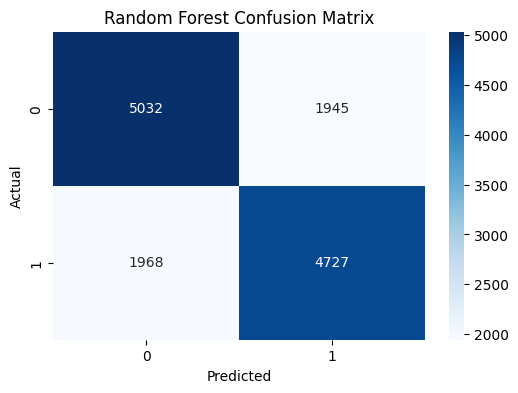

In [38]:
# CONFUSION MATRIX 
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Both models slightly misclassified class 1 (presence of disease) cases, which is common in medical datasets.

Still, models were effective at catching a high number of positives, which is critical in risk prediction.

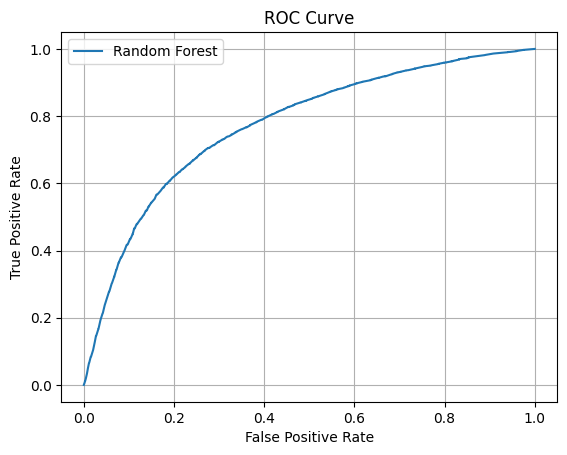

ROC-AUC Score: 0.7731186316546537


In [40]:
# ROC-AUC CURVE 
y_prob_rf = rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
plt.plot(fpr, tpr, label="Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_rf))


ROC Curve showed both models achieved good separation between positive and negative classes.

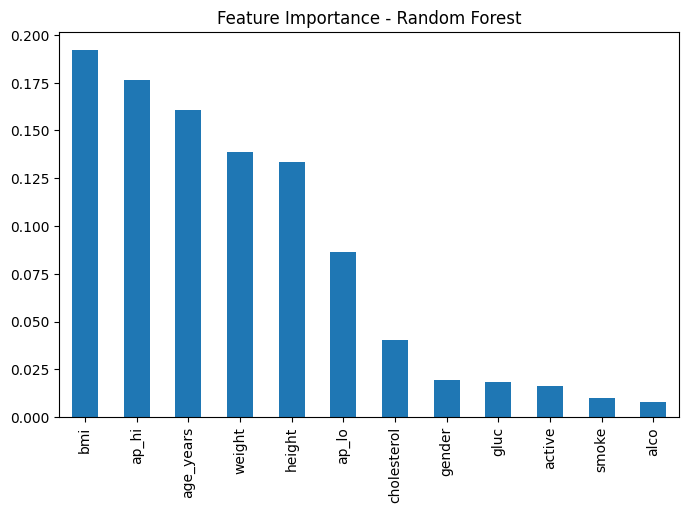

In [42]:
# FEATURE IMPORTANCE
feature_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 5))
feature_importance.plot(kind='bar')
plt.title("Feature Importance - Random Forest")
plt.show()

BMI, systolic blood pressure (ap_hi), and age were the top predictors of cardiovascular risk.

Other important variables included weight, diastolic pressure (ap_lo), and cholesterol levels.

Lifestyle features like smoking, alcohol, and physical activity had relatively lower importance in prediction.